In [ ]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import (
    Predictive,
    SVI,
    TraceMeanField_ELBO,
    autoguide,
    init_to_feasible,
)
import flax.linen as nn
from numpyro.util import format_shapes
from numpyro.contrib.module import random_flax_module, flax_module

# from helper import get_default_optimizer
from flax.nnx import display

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns

import inspeqtor.experimental as sq

### Helper functions

In [3]:
def generate_data():
    # Parameters
    a = 0.3
    b = 2.5
    s = 0.25

    # True function
    def y_true(x):
        return a + jnp.sin(x * 2 * jnp.pi / b)

    # Noisy function
    def y_noise(x, key):
        return y_true(x) + s * jax.random.normal(key, x.shape)

    return y_true, y_noise


def inspect_model(model, *args, key=None):
    key = key if key is not None else jax.random.key(0)
    model = handlers.seed(model, key)
    return handlers.trace(model).get_trace(*args)


def construct_normal_prior(
    posterior_samples: dict[str, jnp.ndarray],
) -> dict[str, dist.Distribution]:
    posterior_mean = jax.tree.map(lambda x: jnp.mean(x, axis=0), posterior_samples)
    posterior_std = jax.tree.map(lambda x: jnp.std(x, axis=0), posterior_samples)

    prior = {}
    for name, mean in posterior_mean.items():
        prior[name] = dist.Normal(mean, posterior_std[name])

    return prior

### Model and marginal guide

In [13]:
# Simple flax MLP model
class MLP(nn.Module):
    layers: list[int]

    @nn.compact
    def __call__(self, x):
        for hidden in self.layers:
            x = nn.Dense(hidden)(x)
            x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x


def make_bmlp_model(
    layer_size: list[int] = [5],
    using_bayesian: bool = False,
    bnn_prior: dist.Distribution | dict[str, dist.Distribution] = dist.Normal(0, 1.0),
    sigma_prior: dist.Distribution = dist.LogNormal(0, 1),
):
    def BNN_model(input_shape):
        # This function convert flax model into numpyro model and make it Bayesian
        return random_flax_module(
            "MLP",
            MLP(layer_size),
            input_shape=input_shape,
            prior=bnn_prior,
        )

    def NN_model(input_shape):
        # This function convert flax model into numpyro model
        return flax_module("MLP", MLP(layer_size), input_shape=input_shape)

    def probabilistic_model_v2(x: jnp.ndarray, y: jnp.ndarray | None = None):
        # Expect x to be shape of (...batch_dims, 1)
        mlp = BNN_model(x.shape) if using_bayesian else NN_model(x.shape)

        # Output shape is (..., 1)
        mu = mlp(x)
        # So we squeeze the last dimension
        mu = jnp.squeeze(mu, axis=-1)
        sigma = numpyro.sample("sigma", sigma_prior)

        return numpyro.sample("y", dist.Normal(mu, sigma), obs=y)  # type: ignore

    return probabilistic_model_v2


def make_bmlp_marginal_guide(is_range_design: bool = False):
    # NOTE: Marginal guide is not the guide used in optimizing the BNN model, but in BOED

    design_dim = -2 if not is_range_design else -3

    def marginal_guide_v3(
        design: jnp.ndarray, observation_labels: list[str], target_labels: list[str]
    ):
        # -1 at the end is for the output dimension, so we dont't have to squeeze it later
        mean = numpyro.param("mean", jnp.zeros(design.shape[design_dim:-1]))
        # Alternatively, we could use `to_event` to make the distribution over the last dimension
        return numpyro.sample("y", dist.Normal(mean, 1))  # type: ignore

    return marginal_guide_v3

### Inspecting the probabilistic model

In [14]:
test_input = jnp.ones(
    (
        10,
        1,
    )
)
model = make_bmlp_model()
# Inspect the model
model_trace = inspect_model(model, test_input)
print(format_shapes(model_trace))
# pprint.pp(model_trace)
display(model_trace)

Trace Shapes:     
 Param Sites:     
   MLP$params     
Sample Sites:     
   sigma dist    |
        value    |
       y dist 10 |
        value 10 |


### Train the model and guide

In [42]:
n_iterations = 10000
optimizer = sq.optimize.get_default_optimizer(n_iterations=n_iterations)
key = jax.random.key(0)
key, subkey = jax.random.split(key)

true_fn, noisy_fn = generate_data()

n_observations = 100
x = jnp.linspace(-1.5, 1.5, n_observations)
y = noisy_fn(x, subkey)

model = make_bmlp_model(using_bayesian=True)
guide = autoguide.AutoDiagonalNormal(model, init_loc_fn=init_to_feasible)

svi = SVI(
    model,
    guide,
    numpyro.optim.optax_to_numpyro(optimizer),
    TraceMeanField_ELBO(),
)

key, subkey = jax.random.split(key)

svi_result = svi.run(
    rng_key=subkey,
    num_steps=int(n_iterations * 1.2),
    x=x.reshape(-1, 1),
    y=y,
)

100%|██████████| 12000/12000 [00:01<00:00, 7200.20it/s, init loss: 157.6738, avg. loss [11401-12000]: 81.3387]


### Inference

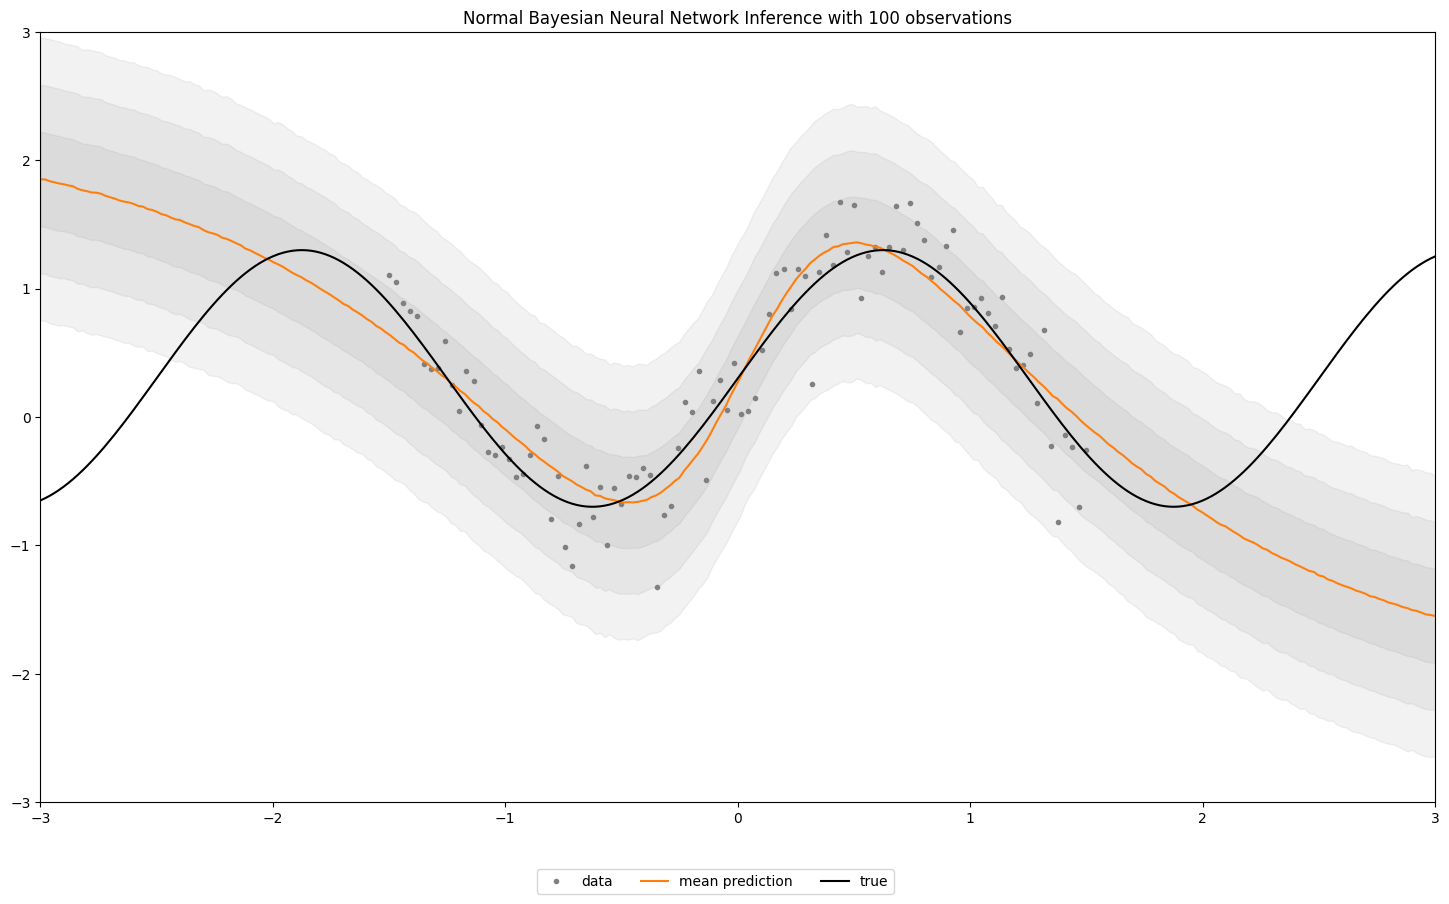

In [43]:
params, losses = svi_result.params, svi_result.losses
predictive = Predictive(model, guide=guide, params=params, num_samples=10_000)
key, subkey = jax.random.split(key)
x_test = jnp.linspace(-3.0, 3.0, num=300).reshape(-1, 1)

samples = predictive(
    subkey,
    x=x_test,
)

y_pred = samples["y"]
# plot the results
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, y, ".", label="data", color="gray")
ax.plot(x_test, y_pred.mean(0), "-", label="mean prediction", color="C1")
# STD of the prediction
for std_factor in [1, 2, 3]:
    ax.fill_between(
        x_test.reshape(-1),
        y_pred.mean(0) - std_factor * y_pred.std(0),
        y_pred.mean(0) + std_factor * y_pred.std(0),
        alpha=0.10,
        color="gray",
    )

ax.plot(x_test, true_fn(x_test), label="true", color="black")
# ax.set_ylim(-3.0, 3.0)
ax.set_title(
    f"Normal Bayesian Neural Network Inference with {n_observations} observations"
)
ax.set_ylim(-3.0, 3.0)
ax.set_xlim(-3.0, 3.0)
fig.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    ncol=4,
)

### Two ways of making pre-trained BNN model

In [45]:
# model = make_bmlp_model(using_bayesian=True)
# guide = autoguide.AutoDiagonalNormal(model, init_loc_fn=init_to_feasible)

posterior_samples = guide.sample_posterior(
    jax.random.key(0), svi_result.params, sample_shape=(10000,)
)

priors = construct_normal_prior(posterior_samples)
bmlp_priors = {
    name.split("/")[1]: prior
    for name, prior in priors.items()
    if name.startswith("MLP/")
}

pretrained_model = make_bmlp_model(
    using_bayesian=True,
    bnn_prior=bmlp_priors,
    sigma_prior=dist.Normal(
        priors["sigma"].get_args()["loc"], priors["sigma"].get_args()["scale"]
    ),
)

### Calculate Expected Information Gain (EIG)

In [ ]:
# # Extract the parameters
# # guide = handlers.substitute(guide, svi_result.params)
# # use guide to get the sample of parameters for the model
# # use mean of the parameters as prior of the model
# key, subkey = jax.random.split(key)
# guide = handlers.substitute(guide, svi_result.params)
# posterior_samples = _predictive(
#     rng_key=subkey,
#     model=guide,
#     posterior_samples={},
#     batch_shape=(1000,),
#     return_sites="",
#     parallel=False,
#     model_args=(x.reshape(-1, 1),),
#     model_kwargs={},
#     exclude_deterministic=True,
# )
# # Average over the samples to get the posterior
# posterior = jax.tree.map(lambda x: jnp.mean(x, axis=0), posterior_samples)
new_model = make_bmlp_model(using_bayesian=True)
# pretrained_model = handlers.substitute(new_model, posterior)

In [46]:
# NOTE: Play with the `USE_PRETRAINED`
USE_PRETRAINED = True
x_candidate_designs = jnp.linspace(-3.0, 3.0, num=100).reshape(-1, 1)
n_opitimization_steps = 1000
optimizer = sq.optimize.get_default_optimizer(n_opitimization_steps)
key, subkey = jax.random.split(key)

In [47]:
point_eig, state = sq.boed.marginal_eig(
    key=subkey,
    model=pretrained_model if USE_PRETRAINED else new_model,
    marginal_guide=make_bmlp_marginal_guide(is_range_design=False),
    design=x_candidate_designs,
    optimizer=optimizer,
    num_optimization_steps=n_opitimization_steps,
    observation_labels=["y"],
    target_labels=["theta"],
    num_particles=1000,
    final_num_particles=10_000,
)

|████████████████████████████████████████| 1000/1000 [100%] in 8.8s (114.12/s)  


#### Visualizing the results

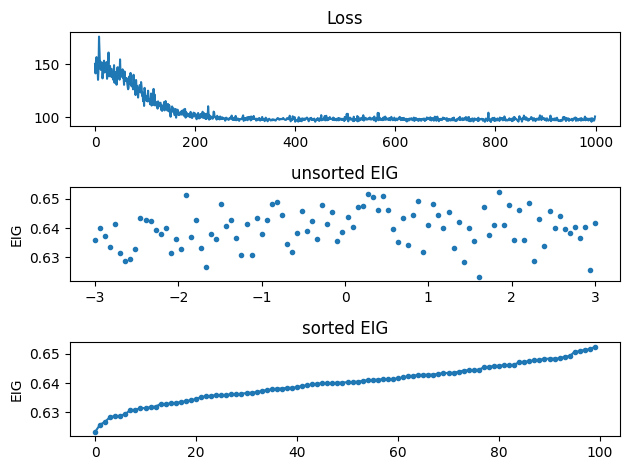

In [48]:
loss = jnp.array([items[1] for items in state["history"]])
fig, axes = plt.subplots(3, 1)
# 1. Plot the loss
axes[0].plot(loss)
# Log scale
# axes[0].set_yscale("log")
axes[0].set_title("Loss")
# 2. Plot unsorted Expected Information Gain (EIG)
axes[1].plot(x_candidate_designs, point_eig, ".")
axes[1].set_title("unsorted EIG")
axes[1].set_ylabel("EIG")
# 3. Plot sorted EIG
axes[2].plot(jnp.sort(point_eig), ".-")
axes[2].set_title("sorted EIG")
axes[2].set_ylabel("EIG")
fig.tight_layout()

#### BOED over range designs


In [50]:
x_candidate_designs = jnp.linspace(-3.0, 3.0, num=100).reshape(10, 10, 1)

range_eig, state = sq.boed.marginal_eig(
    key=subkey,
    model=pretrained_model if USE_PRETRAINED else new_model,
    marginal_guide=make_bmlp_marginal_guide(is_range_design=True),
    design=x_candidate_designs,
    optimizer=optimizer,
    num_optimization_steps=n_opitimization_steps,
    observation_labels=["y"],
    target_labels=["theta"],
    num_particles=1000,
    final_num_particles=10_000,
)

|████████████████████████████████████████| 1000/1000 [100%] in 8.8s (112.95/s)  


#### Compare the results

We can see that batch design is equivalent to the single design in this case.

In [51]:
jnp.allclose(point_eig, range_eig.flatten())

Array(True, dtype=bool)

### Simple Optimal Experiment step

In [66]:
FAST_MODE = False
N_EXPERIMENTS = 10 if not FAST_MODE else 2
N_SELECTED_DESIGNS = 10

x_candidate_designs = jnp.linspace(-1.5, 1.5, num=100).reshape(-1, 1)
n_opitimization_steps = 1000 if not FAST_MODE else 10

model = make_bmlp_model(using_bayesian=True)
guide = autoguide.AutoNormal(model, init_loc_fn=init_to_feasible)

x_train = jnp.empty((0, 1))
y_train = jnp.empty((0,))
key = jax.random.key(1)
n_iterations = 10_000
optimizer = sq.optimize.get_default_optimizer(n_iterations=n_iterations)

for i in range(1, N_EXPERIMENTS + 1):
    print(f"Experiment {i}/{N_EXPERIMENTS}")

    key, subkey = jax.random.split(key)
    eig, state = sq.boed.marginal_eig(
        key=subkey,
        model=model,
        marginal_guide=make_bmlp_marginal_guide(is_range_design=False),
        design=x_candidate_designs,
        optimizer=sq.optimize.get_default_optimizer(n_opitimization_steps),
        num_optimization_steps=n_opitimization_steps,
        observation_labels=["y"],
        target_labels=["theta"],
        num_particles=1000,
        final_num_particles=10_000,
    )

    selected_x_designs = x_candidate_designs[jnp.argsort(eig, descending=True)][
        :N_SELECTED_DESIGNS
    ]

    key, subkey = jax.random.split(key)

    x_train = jnp.concatenate([x_train, selected_x_designs], axis=0)
    y_train = jnp.concatenate(
        [y_train, noisy_fn(selected_x_designs, subkey).reshape(-1)]
    )

    model = make_bmlp_model(using_bayesian=True)
    guide = autoguide.AutoNormal(model, init_loc_fn=init_to_feasible)
    svi = SVI(
        model,
        guide,
        numpyro.optim.optax_to_numpyro(optimizer),
        TraceMeanField_ELBO(),
    )

    key, subkey = jax.random.split(key)

    svi_result = svi.run(
        rng_key=subkey,
        num_steps=int(n_iterations * 1.2),
        x=x_train,
        y=y_train,
    )

    # Extract the parameters
    key, subkey = jax.random.split(key)
    # ! This is the benefit of using autoguide. We can use the same guide to sample the posterior.
    # posterior_samples = guide.sample_posterior(
    #     subkey, svi_result.params, sample_shape=(1000,)
    # )

    # """
    # # ! If we use a custom guide, we need to substitute the guide with the parameters
    # # Use guide to get the sample of parameters for the model
    # guide = handlers.substitute(guide, svi_result.params)
    # # use mean of the parameters as prior of the model
    # key, subkey = jax.random.split(key)
    # posterior_samples = _predictive(
    #     rng_key=subkey,
    #     model=handlers.substitute(guide, svi_result.params),
    #     posterior_samples={},
    #     batch_shape=(1000,),
    #     return_sites="",
    #     parallel=False,
    #     model_args=(x_train,),
    #     model_kwargs={},
    #     exclude_deterministic=True,
    # )
    # """

    # posterior = jax.tree.map(lambda x: jnp.mean(x, axis=0), posterior_samples)
    # model = handlers.substitute(model, posterior)

    posterior_samples = guide.sample_posterior(
        jax.random.key(0), svi_result.params, sample_shape=(10000,)
    )

    priors = construct_normal_prior(posterior_samples)
    bmlp_priors = {
        name.split("/")[1]: prior
        for name, prior in priors.items()
        if name.startswith("MLP/")
    }

    model = make_bmlp_model(
        using_bayesian=True,
        bnn_prior=bmlp_priors,
        sigma_prior=dist.Normal(
            priors["sigma"].get_args()["loc"], priors["sigma"].get_args()["scale"]
        ),
    )

Experiment 1/10
|████████████████████████████████████████| 1000/1000 [100%] in 9.3s (107.76/s)  


100%|██████████| 12000/12000 [00:02<00:00, 5039.22it/s, init loss: 41.3564, avg. loss [11401-12000]: 14.8827]


Experiment 2/10
|████████████████████████████████████████| 1000/1000 [100%] in 8.3s (121.30/s)  


100%|██████████| 12000/12000 [00:02<00:00, 5474.62it/s, init loss: 53.4873, avg. loss [11401-12000]: 26.9030]


Experiment 3/10
|████████████████████████████████████████| 1000/1000 [100%] in 8.4s (118.58/s)  


100%|██████████| 12000/12000 [00:02<00:00, 5308.05it/s, init loss: 64.2290, avg. loss [11401-12000]: 34.3327]


Experiment 4/10
|████████████████████████████████████████| 1000/1000 [100%] in 8.3s (120.50/s)  


100%|██████████| 12000/12000 [00:02<00:00, 4874.36it/s, init loss: 72.1569, avg. loss [11401-12000]: 42.0032]


Experiment 5/10
|████████████████████████████████████████| 1000/1000 [100%] in 8.3s (120.58/s)  


100%|██████████| 12000/12000 [00:02<00:00, 5396.15it/s, init loss: 85.3405, avg. loss [11401-12000]: 55.8390]


Experiment 6/10
|████████████████████████████████████████| 1000/1000 [100%] in 8.4s (119.02/s)  


100%|██████████| 12000/12000 [00:02<00:00, 5261.42it/s, init loss: 98.5714, avg. loss [11401-12000]: 73.1363]


Experiment 7/10
|████████████████████████████████████████| 1000/1000 [100%] in 8.6s (116.74/s)  


100%|██████████| 12000/12000 [00:02<00:00, 4951.86it/s, init loss: 118.9182, avg. loss [11401-12000]: 65.0877]


Experiment 8/10
|████████████████████████████████████████| 1000/1000 [100%] in 8.4s (119.15/s)  


100%|██████████| 12000/12000 [00:02<00:00, 4865.30it/s, init loss: 129.7520, avg. loss [11401-12000]: 73.2041]


Experiment 9/10
|████████████████████████████████████████| 1000/1000 [100%] in 8.5s (118.04/s)  


100%|██████████| 12000/12000 [00:02<00:00, 4808.09it/s, init loss: 137.1886, avg. loss [11401-12000]: 57.2293]


Experiment 10/10
|████████████████████████████████████████| 1000/1000 [100%] in 8.5s (118.38/s)  


100%|██████████| 12000/12000 [00:02<00:00, 4710.81it/s, init loss: 151.8971, avg. loss [11401-12000]: 56.9490]


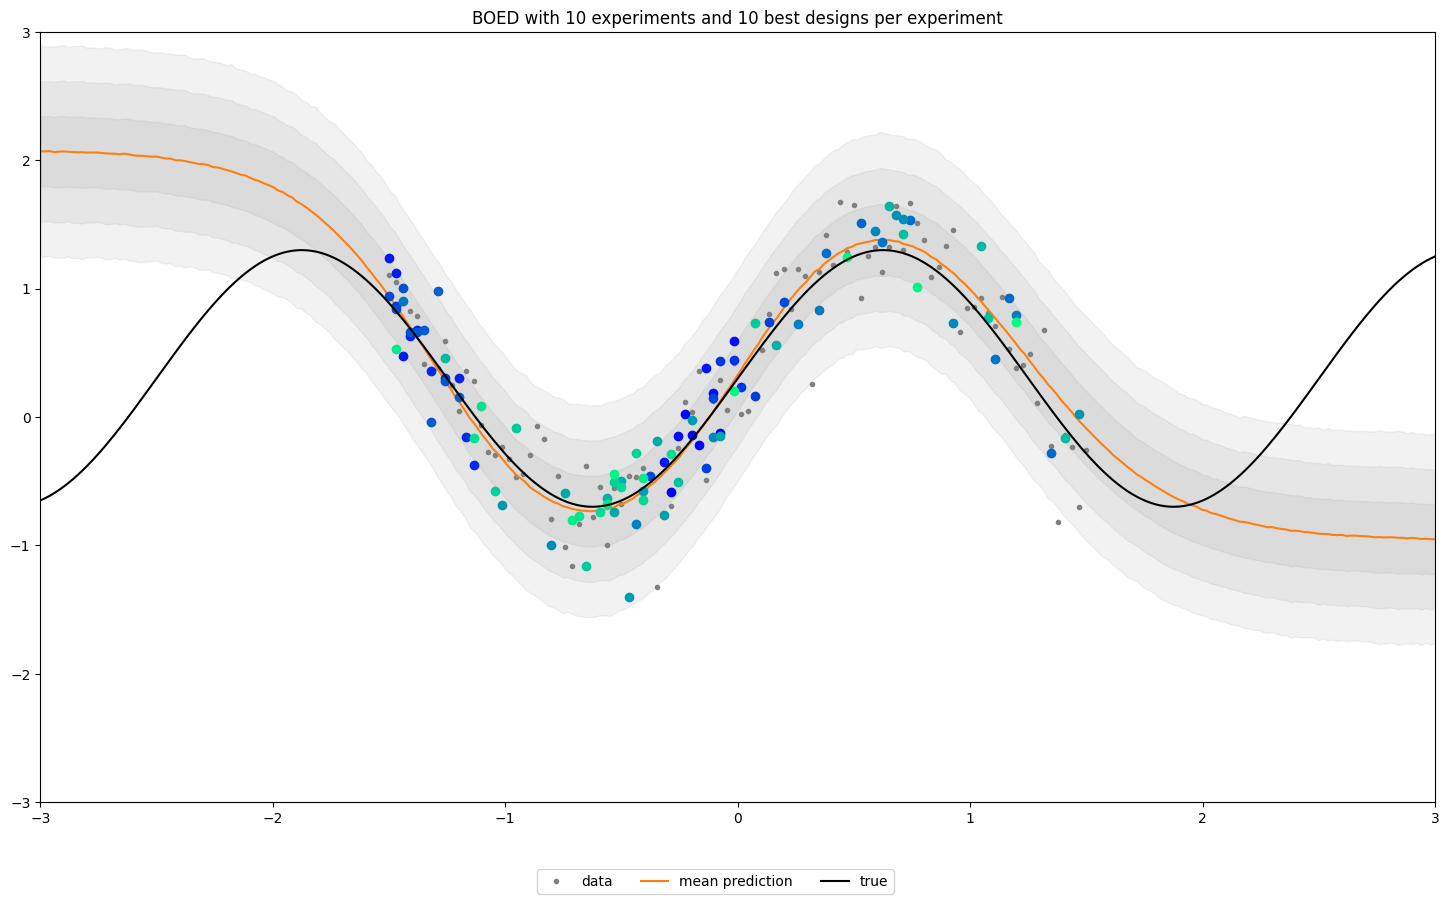

In [67]:
params, losses = svi_result.params, svi_result.losses
predictive = Predictive(model, guide=guide, params=params, num_samples=10_000)
key, subkey = jax.random.split(key)

x_test = jnp.linspace(-3.0, 3.0, num=300).reshape(-1, 1)

samples = predictive(
    subkey,
    x=x_test,
)
y_pred = samples["y"]
y_pred.shape

# plot the results
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, y, ".", label="data", color="gray")
ax.plot(x_test, y_pred.mean(0), "-", label="mean prediction", color="C1")

cmap = plt.get_cmap("winter")
cNorm = colors.Normalize(vmin=0, vmax=x_train.shape[0])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
for idx, (_x, _y) in enumerate(zip(x_train, y_train)):
    ax.plot(_x, _y, "o", color=scalarMap.to_rgba(idx))

# STD of the prediction
for std_factor in [1, 2, 3]:
    ax.fill_between(
        x_test.reshape(-1),
        y_pred.mean(0) - std_factor * y_pred.std(0),
        y_pred.mean(0) + std_factor * y_pred.std(0),
        alpha=0.10,
        color="gray",
    )

ax.plot(x_test, true_fn(x_test), label="true", color="black")
ax.set_title(
    f"BOED with {N_EXPERIMENTS} experiments and {N_SELECTED_DESIGNS} best designs per experiment"
)
ax.set_ylim(-3.0, 3.0)
ax.set_xlim(-3.0, 3.0)
fig.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    ncol=4,
)

#### Visualize the data section

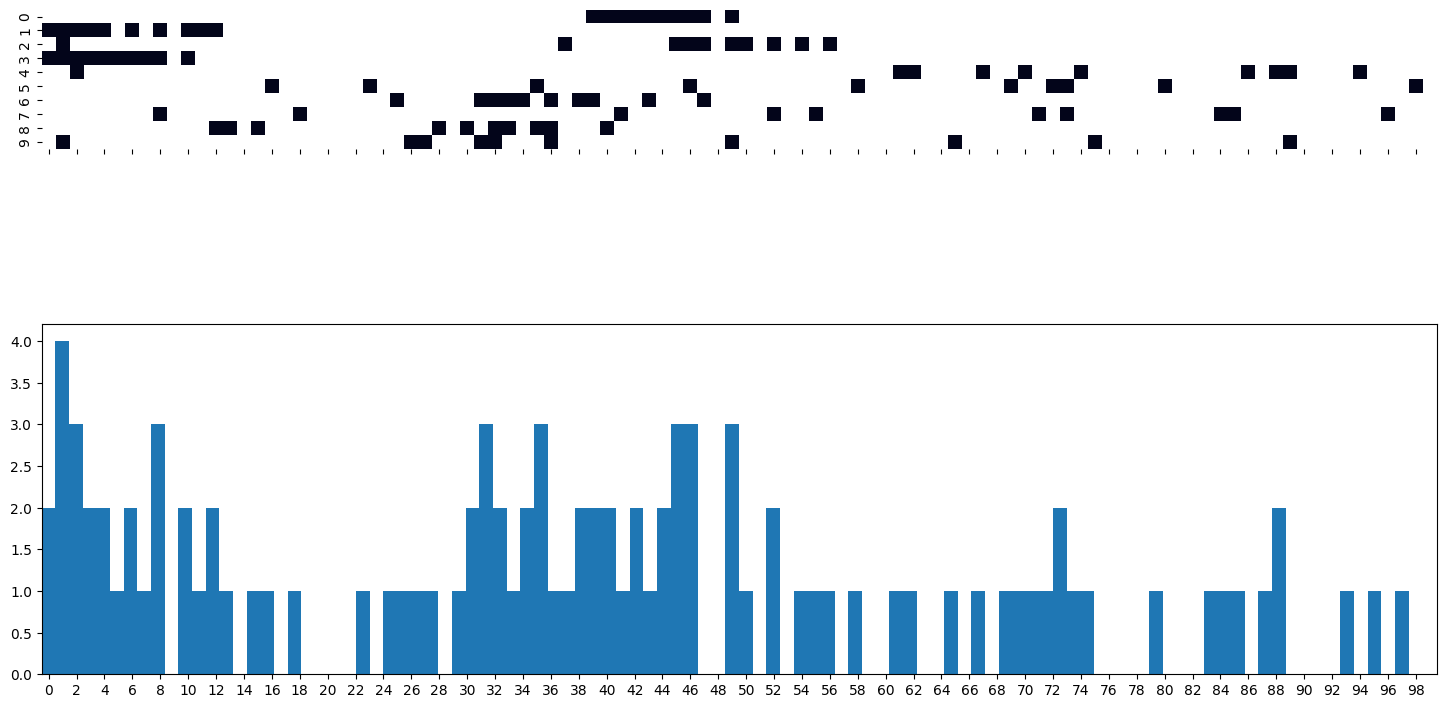

In [56]:
x_candidate_designs = jnp.linspace(-1.5, 1.5, num=100)

exp_selected_designs = []
indices = []
for candidates in x_train.reshape((N_EXPERIMENTS, N_SELECTED_DESIGNS)):
    candidates_in_designs = jax.vmap(lambda x: jnp.isin(x, candidates), in_axes=(0,))(
        x_candidate_designs
    ).astype(jnp.float32)
    # Convert 0.0 to jnp.nan
    candidates_in_designs = jnp.where(
        candidates_in_designs == 0.0, jnp.nan, candidates_in_designs
    )
    indices.append(jnp.where(candidates_in_designs == 1.0))
    exp_selected_designs.append(candidates_in_designs)

exp_selected_designs = jnp.array(exp_selected_designs)
indices = jnp.array(indices).flatten()

cNorm = colors.Normalize(vmin=0, vmax=1)

# Plot the heatmap
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
sns.heatmap(
    data=exp_selected_designs,
    square=True,
    cbar=False,
    ax=axes[0],
)

# Plot histogram of indices
_ = axes[1].hist(indices, bins=100)